In [15]:
import pandas as pd
import spacy
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import mannwhitneyu
from statistics import mean
from scipy.stats import norm
import numpy as np
import scipy.stats as stats
import seaborn as sns
from matplotlib.colors import ListedColormap
from collections import Counter
import geopandas as gpd

In [16]:
# Define the directory path
directory_path = r'C:\Users\tiffa.TIFFANY\OneDrive\Documents\DS 5460 - Big Data Scaling\Final Project\data\usa\Broward County'

# File names
listings = 'listings.csv'
listings_detailed = 'listings_detailed.csv'
reviews = 'reviews.csv'
reviews_detailed = 'reviews_detailed.csv'
calendar = 'calendar.csv'
neighbourhoods = 'neighbourhoods.csv'
neighbourhoods_json = 'neighbourhoods.geojson'


# Full paths to read in later
calendar_path = directory_path + '\\' + calendar
listings_detailed_path = directory_path + '\\' + listings_detailed
listings_path = directory_path + '\\' + listings
reviews_path = directory_path + '\\' + reviews
reviews_detailed_path = directory_path + '\\' + reviews_detailed
neighbourhoods_path = directory_path + '\\' + neighbourhoods
neighbourhoods_json_path = directory_path + '\\' + neighbourhoods_json


## 1. calendar_df EDA

In [17]:
# Read in the calendar_df
calendar_df = pd.read_csv(calendar_path,  na_filter=False)

C:\Users\tiffa.TIFFANY\AppData\Local\Temp\ipykernel_8304\2388504879.py:2: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  calendar_df = pd.read_csv(calendar_path,  na_filter=False)


#### Adjust Calendar datatypes to be numeric or date

In [18]:

calendar_df['minimum_nights'] = pd.to_numeric(calendar_df['minimum_nights'], errors='coerce')
calendar_df['maximum_nights'] = pd.to_numeric(calendar_df['maximum_nights'], errors='coerce')

# Chnge price cols to numeric
calendar_df['price'] = pd.to_numeric(calendar_df['price'].str.replace('$', '').str.replace(',', ''), errors='coerce')
calendar_df['adjusted_price'] = pd.to_numeric(calendar_df['adjusted_price'].str.replace('$', '').str.replace(',', ''), errors='coerce')

calendar_df['date'] = pd.to_datetime(calendar_df['date']).dt.date

calendar_df.head()

C:\Users\tiffa.TIFFANY\AppData\Local\Temp\ipykernel_8304\1229068016.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  calendar_df['price'] = pd.to_numeric(calendar_df['price'].str.replace('$', '').str.replace(',', ''), errors='coerce')
C:\Users\tiffa.TIFFANY\AppData\Local\Temp\ipykernel_8304\1229068016.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  calendar_df['adjusted_price'] = pd.to_numeric(calendar_df['adjusted_price'].str.replace('$', '').str.replace(',', ''), errors='coerce')


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,69824,2023-03-28,f,150.0,150.0,30.0,365.0
1,69824,2023-03-29,f,150.0,150.0,30.0,365.0
2,69824,2023-03-30,f,150.0,150.0,30.0,365.0
3,69824,2023-03-31,t,150.0,150.0,30.0,365.0
4,69824,2023-04-01,t,150.0,150.0,30.0,365.0


In [19]:
calendar_df.shape

(6168116, 7)

### Count Number of Missing Values in calendar_df

In [20]:
pd.set_option('display.max_columns', None)  # Adjust to see all columns
pd.set_option('display.max_rows', None)  # Adjust to see all rows

missing_values_count = calendar_df.isna().sum()

# Filter to only show columns with missing values > 0
missing_values_count = missing_values_count[missing_values_count > 0]

print(missing_values_count)

price             682
adjusted_price    682
minimum_nights      1
maximum_nights      1
dtype: int64


#### calendar_df Column Ranges

In [21]:
range_values = calendar_df.describe().loc[['min', 'max']].T

print("Range values of each column:")
print(range_values)

# Find the first and last date
first_date = calendar_df['date'].min()
last_date = calendar_df['date'].max()

print("First date in the Date column:", first_date)
print("Last date in the Date column:", last_date)

Range values of each column:
                    min           max
listing_id      57818.0  8.559792e+17
price               0.0  1.000000e+05
adjusted_price      0.0  1.000000e+05
minimum_nights      1.0  5.000000e+02
maximum_nights      1.0  2.147484e+09
First date in the Date column: 2023-03-27
Last date in the Date column: 2024-03-31


#### calendar_df instances where adjusted_price is not the same as price

In [22]:
price_mismatch_count = calendar_df[calendar_df['adjusted_price'] != calendar_df['price']].shape[0]

print("Number of instances where adjusted price column not equal price column:",price_mismatch_count)

Number of instances where adjusted price column not equal price column: 430126


#### calendar_df first 10 listings adjusted price over time

Seeing what does the adjusted price look like for the first 10 listings 

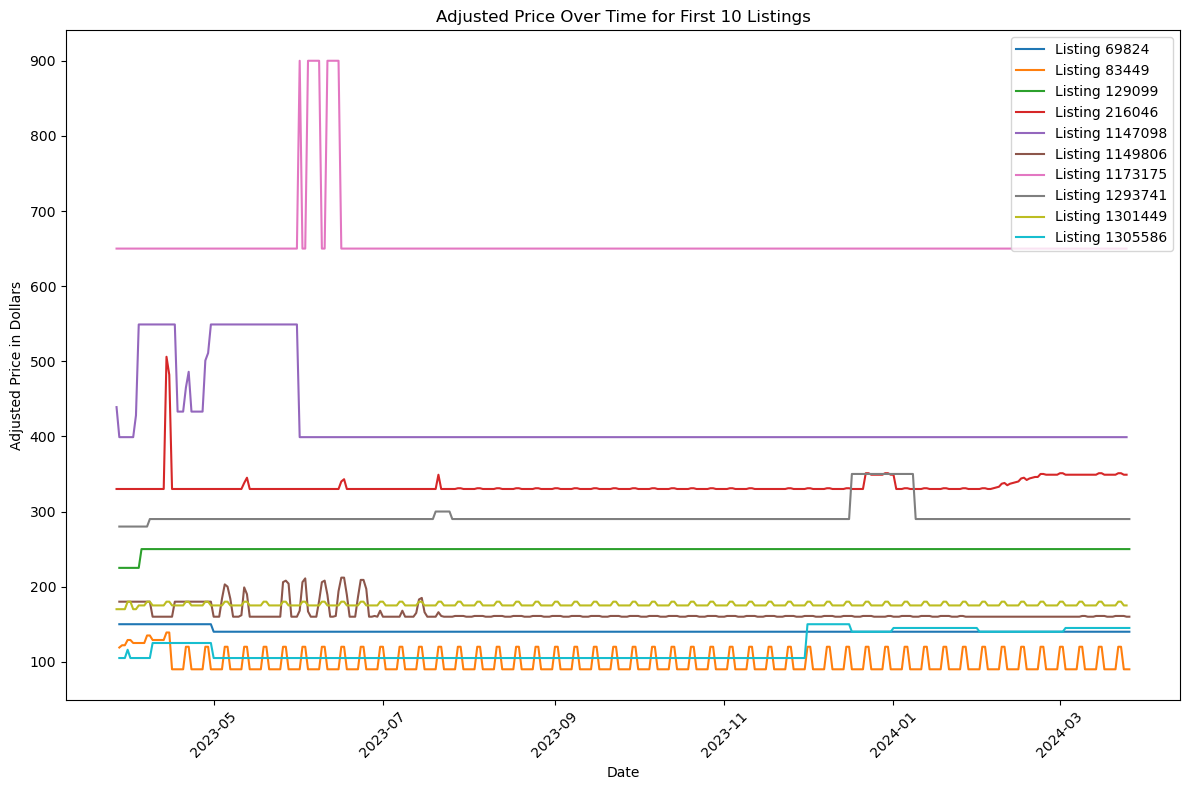

In [23]:
# Get the unique list of the first 10 listing_ids to do the group
unique_listing_ids = calendar_df['listing_id'].unique()[:10]

plt.figure(figsize=(12, 8))

# Loop through each unique listing_id and plot its adjusted_price over time
for listing_id in unique_listing_ids:
    subset = calendar_df[calendar_df['listing_id'] == listing_id]
    plt.plot(subset['date'], subset['adjusted_price'], label=f'Listing {listing_id}')

plt.title('Adjusted Price Over Time for First 10 Listings')
plt.xlabel('Date')
plt.ylabel('Adjusted Price in Dollars')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

#### Calculate mean, standard deviation, and median for first 10 listings

In [24]:
# Calculate mean, standard deviation, and median for each listing group for the first 10 lisitngs
stats_df = calendar_df[calendar_df['listing_id'].isin(unique_listing_ids)].groupby('listing_id')['adjusted_price'].agg(['mean', 'std', 'median'])

stats_df.reset_index(inplace=True)
stats_df

,listing_id,mean,std,median
0,69824,140.931507,2.910424,140.0
1,83449,100.052055,14.809413,90.0
2,129099,249.452055,3.665405,250.0
3,216046,333.956164,13.635895,330.0
4,1147098,419.843836,50.355388,399.0
5,1149806,164.498630,10.827728,160.0
6,1173175,657.534247,42.799713,650.0
7,1293741,293.643836,14.792865,290.0
8,1301449,176.342466,2.397453,175.0
9,1305586,118.646575,17.981783,105.0


#### calendar_df first 10 listings for availability over time via heatmap

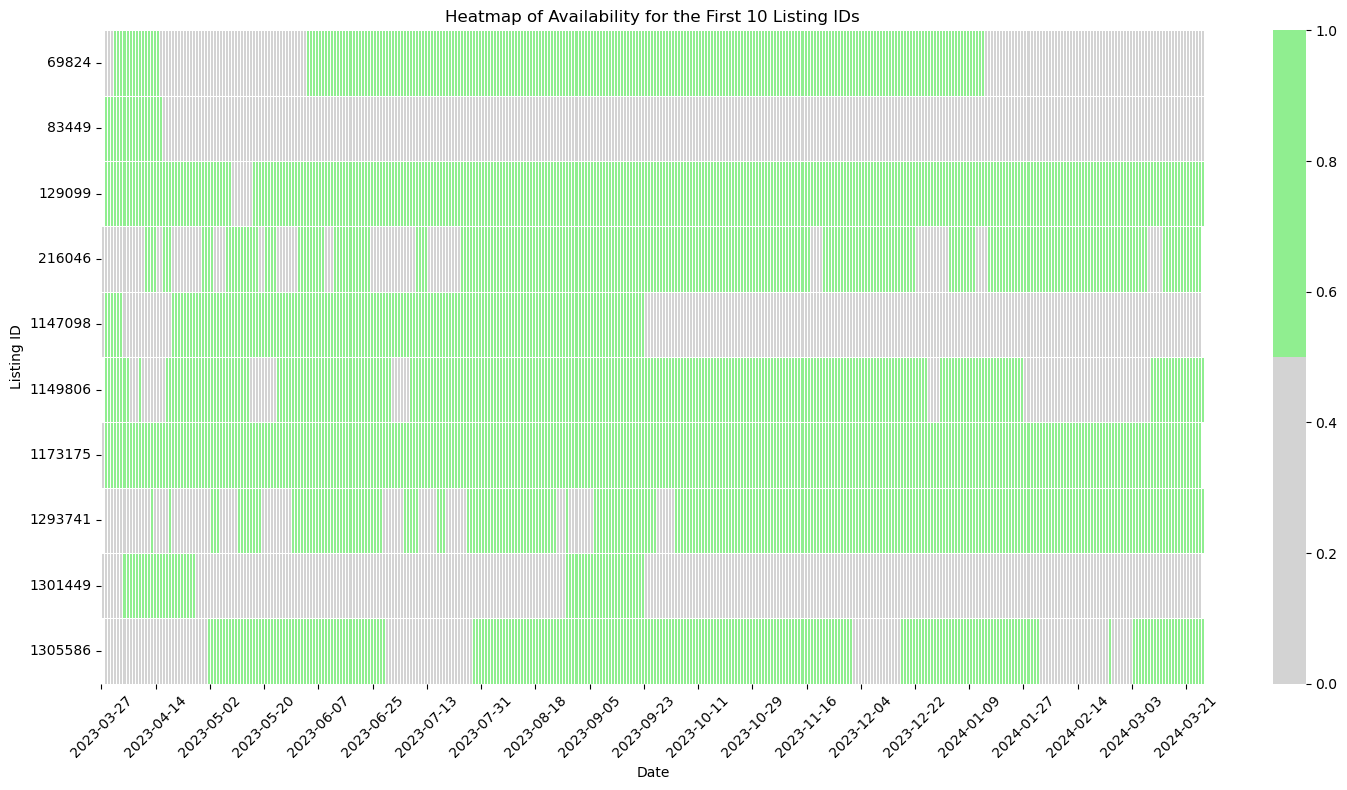

In [25]:
# Create binary representation for availability
calendar_df['available_binary'] = calendar_df['available'].map({'t': 1, 'f': 0})

# Get the first 10 unique listing_ids
unique_ids = calendar_df['listing_id'].unique()[:10]
filtered_calendar = calendar_df[calendar_df['listing_id'].isin(unique_ids)]

availability_matrix = filtered_calendar.pivot_table(index='listing_id', 
                                                    columns='date', 
                                                    values='available_binary', 
                                                    aggfunc='mean')

# Sort the listing_ids by their first appearance in the dataset
availability_matrix = availability_matrix.loc[unique_ids]

# Create a custom color map for the heatmap
cmap = ListedColormap(['lightgrey', 'lightgreen'])

plt.figure(figsize=(15, 8))
sns.heatmap(availability_matrix, cmap=cmap, cbar=True, linewidths=.5)

plt.title('Heatmap of Availability for the First 10 Listing IDs')
plt.xlabel('Date')
plt.ylabel('Listing ID')

# Set x-axis ticks to be less dense and rotate them for better readability
date_range = pd.date_range(start=calendar_df['date'].min(), end=calendar_df['date'].max())
date_format = "%Y-%m-%d"  # Define date format
plt.xticks(ticks=range(0, len(date_range), int(len(date_range)/20)),  # Show a tick every 5% of the range
           labels=[date.strftime(date_format) for date in date_range[::int(len(date_range)/20)]],  # Label format
           rotation=45)

plt.tight_layout()

plt.show()

#### Mean Adjusted Price Over Time for the entire dataset for all listings IDs

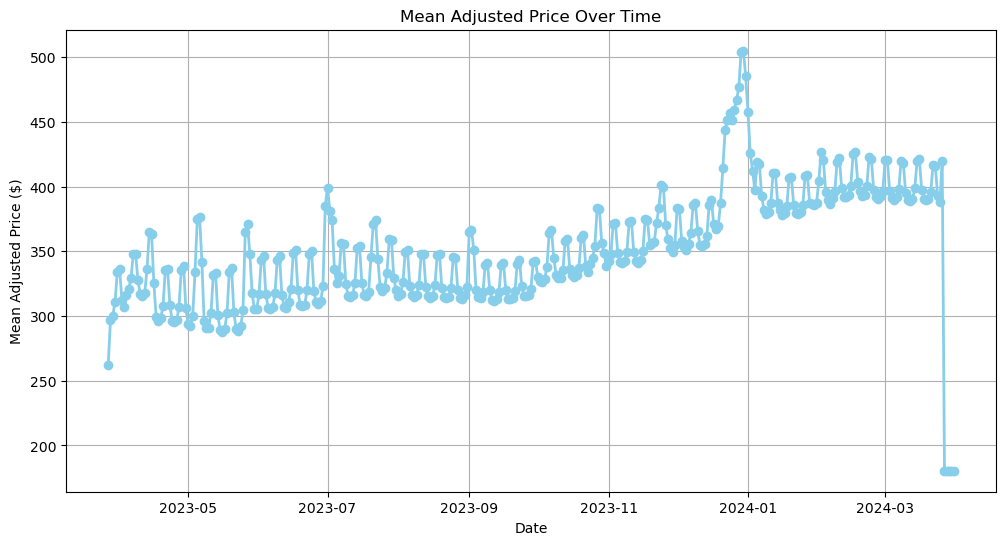

In [26]:
# Group by date and calculate the mean of 'adjusted_price' for each date
mean_price_over_time = calendar_df.groupby('date')['adjusted_price'].mean()

plt.figure(figsize=(12, 6))
mean_price_over_time.plot(title='Mean Adjusted Price Over Time', marker='o', color='skyblue', linestyle='-', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Mean Adjusted Price ($)')
plt.grid(True)
plt.show()

## 2. listings_detailed_df EDA

#### Adjust listings_detailed_df datatypes to numeric

In [27]:
# Read in file path
listings_detailed_df = pd.read_csv(listings_detailed_path,  na_filter=False)

# Converting datatypes to numeric
listings_detailed_df['host_response_rate'] = pd.to_numeric(listings_detailed_df['host_response_rate'].str.replace('%', ''), errors='coerce')

listings_detailed_df['host_acceptance_rate'] = pd.to_numeric(listings_detailed_df['host_acceptance_rate'].str.replace('%', ''), errors='coerce')

listings_detailed_df['host_listings_count'] = pd.to_numeric(listings_detailed_df['host_listings_count'], errors='coerce')

listings_detailed_df['price'] = pd.to_numeric(listings_detailed_df['price'].str.replace('$', '').str.replace(',', ''), errors='coerce')

# List of additional column names to convert
columns_to_convert = [
    'host_total_listings_count',
    'bedrooms',
    'beds',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'reviews_per_month'
]

for column in columns_to_convert:
    listings_detailed_df[column] = pd.to_numeric(listings_detailed_df[column], errors='coerce')

C:\Users\tiffa.TIFFANY\AppData\Local\Temp\ipykernel_8304\3247870133.py:2: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  listings_detailed_df = pd.read_csv(listings_detailed_path,  na_filter=False)
C:\Users\tiffa.TIFFANY\AppData\Local\Temp\ipykernel_8304\3247870133.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  listings_detailed_df['price'] = pd.to_numeric(listings_detailed_df['price'].str.replace('$', '').str.replace(',', ''), errors='coerce')


In [28]:
column_dtypes = listings_detailed_df.dtypes

print(column_dtypes)

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
source                                           object
name                                             object
description                                      object
neighborhood_overview                            object
picture_url                                      object
host_id                                           int64
host_url                                         object
host_name                                        object
host_since                                       object
host_location                                    object
host_about                                       object
host_response_time                               object
host_response_rate                              float64
host_acceptance_rate                            

In [29]:
listings_detailed_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,827736378366911479,https://www.airbnb.com/rooms/827736378366911479,20230327145536,2023-03-27,city scrape,Legion 1BR/1BA,Take it easy at this unique and tranquil getaway.,,https://a0.muscache.com/pictures/miso/Hosting-...,475630606,https://www.airbnb.com/users/show/475630606,Sean,2022-08-18,,,within an hour,100.0,94.0,f,https://a0.muscache.com/im/pictures/user/479fc...,https://a0.muscache.com/im/pictures/user/479fc...,Cumberland,2.0,3.0,['phone'],t,t,,Fort Lauderdale,,26.093936,-80.137591,Entire rental unit,Entire home/apt,2,,1 bath,1.0,1.0,"[""Air conditioning"", ""Free parking on premises...",222.0,1,365,1,1,365,365,1.0,365.0,,t,21,51,81,356,2023-03-27,0,0,0,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,t,1,1,0,0,NaN
1,592589963829194972,https://www.airbnb.com/rooms/592589963829194972,20230327145536,2023-03-28,city scrape,Club Wyndham Royal Vista,"Located directly on the beach, the property si...",,https://a0.muscache.com/pictures/8a429c15-ea50...,66506549,https://www.airbnb.com/users/show/66506549,Ryan,2016-04-09,"Alpharetta, GA","Hello, \r\nMy name is Ryan! I really love to ...",within an hour,98.0,16.0,f,https://a0.muscache.com/im/pictures/user/b13a0...,https://a0.muscache.com/im/pictures/user/b13a0...,Waikiki,97.0,112.0,"['email', 'phone']",t,t,,Pompano Beach,,26.223850,-80.090990,Private room in resort,Private room,2,,2 shared baths,2.0,4.0,"[""TV"", ""Paid parking on premises"", ""Indoor fir...",500.0,1,365,1,1,365,365,1.0,365.0,,t,30,60,90,365,2023-03-28,0,0,0,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,f,5,0,5,0,NaN
2,772438920837360569,https://www.airbnb.com/rooms/772438920837360569,20230327145536,2023-03-27,city scrape,Relaxing 5 Acre Ranch home with private pond!,Relax with the whole family at this peaceful p...,,https://a0.muscache.com/pictures/miso/Hosting-...,382318476,https://www.airbnb.com/users/show/382318476,Maggie,2020-12-30,,,within an hour,100.0,89.0,t,https://a0.muscache.com/im/pictures/user/a5740...,https://a0.muscache.com/im/pictures/user/a5740...,Upper East Side,3.0,3.0,"['email', 'phone']",t,t,,Southwest Ranches,,26.033899,-80.334605,Entire home,Entire home/apt,8,,3 baths,4.0,6.0,"[""Air conditioning"", ""Free parking on premises...",500.0,2,365,2,2,365,365,2.0,365.0,,t,29,59,89,89,2023-03-27,2,2,0,2022-12-26,2023-01-02,5.00,5.00,5.00,5.00,5.0,5.00,5.00,,f,1,1,0,0,0.65
3,33271346,https://www.airbnb.com/rooms/33271346,20230327145536,2023-03-28,city scrape,Beach Escape – One Block from the Beach!,Newly constructed and beautifully renovated Ke...,Pompano world-famous coastline is a very popul...,https://a0.muscache.com/pictures/0f2305d2-7400...,118856968,https://www.airbnb.com/users/show/118856968,Steve And Jo,2017-03-02,"Fort La

In [30]:
listings_detailed_df.shape

(16899, 75)

#### Count Number of Missing Values for listings_detailed_df

In [31]:
pd.set_option('display.max_columns', None)  # Adjust to see all columns
pd.set_option('display.max_rows', None)  # Adjust to see all rows

missing_values_count = listings_detailed_df.isna().sum()

# Filter to only show columns with missing values > 0
missing_values_count = missing_values_count[missing_values_count > 0]

print(missing_values_count)

host_response_rate             1322
host_acceptance_rate           1135
host_listings_count               1
host_total_listings_count         1
bedrooms                       1332
beds                            197
review_scores_rating           2837
review_scores_accuracy         2876
review_scores_cleanliness      2876
review_scores_checkin          2876
review_scores_communication    2876
review_scores_location         2876
review_scores_value            2876
reviews_per_month              2837
dtype: int64


#### Get Categorical and Numerical Ranges for listings_detailed_df

In [32]:
for column in listings_detailed_df.columns:
    # Determine if the column is numeric
    if pd.api.types.is_numeric_dtype(listings_detailed_df[column]):
        min_value = listings_detailed_df[column].min()
        max_value = listings_detailed_df[column].max()
        print(f"{column} (Numerical): Range = {min_value} to {max_value}")
    else:
        # For categorical data, display unique values (or count of unique values if too many)
        unique_values = listings_detailed_df[column].unique()
        if len(unique_values) <= 20:  # Arbitrarily chosen threshold for display
            print(f"{column} (Categorical): Categories = {unique_values}")
        else:
            print(f"{column} (Categorical): {len(unique_values)} unique categories")


id (Numerical): Range = 57818 to 855979244654886532
listing_url (Categorical): 16899 unique categories
scrape_id (Numerical): Range = 20230327145536 to 20230327145536
last_scraped (Categorical): Categories = ['2023-03-27' '2023-03-28' '2023-04-02']
source (Categorical): Categories = ['city scrape' 'previous scrape']
name (Categorical): 16068 unique categories
description (Categorical): 14606 unique categories
neighborhood_overview (Categorical): 6998 unique categories
picture_url (Categorical): 16261 unique categories
host_id (Numerical): Range = 5146 to 506759471
host_url (Categorical): 6929 unique categories
host_name (Categorical): 3524 unique categories
host_since (Categorical): 3137 unique categories
host_location (Categorical): 615 unique categories
host_about (Categorical): 2937 unique categories
host_response_time (Categorical): Categories = ['within an hour' 'within a few hours' 'within a day' 'a few days or more'
 'N/A' '']
host_response_rate (Numerical): Range = 0.0 to 100.0

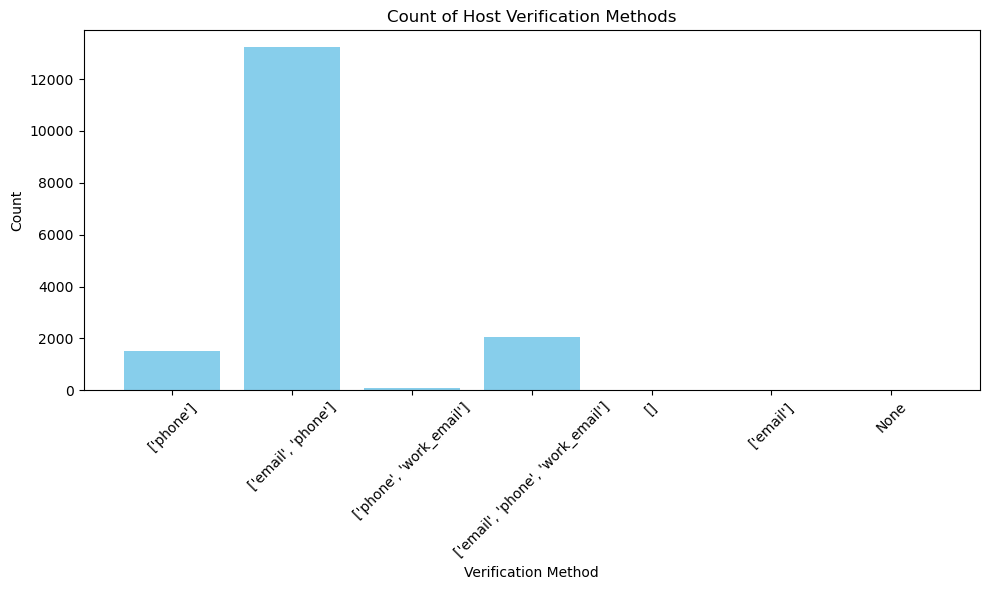

In [33]:
# Explode the DataFrame to make each item in the list a separate row
exploded_df = listings_detailed_df.explode('host_verifications')

# Use Counter to count occurrences of each verification method
verification_counts = Counter(exploded_df['host_verifications'])

# Prepare data for plotting
methods, counts = zip(*verification_counts.items())

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(methods, counts, color='skyblue')
plt.xlabel('Verification Method')
plt.ylabel('Count')
plt.title('Count of Host Verification Methods')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

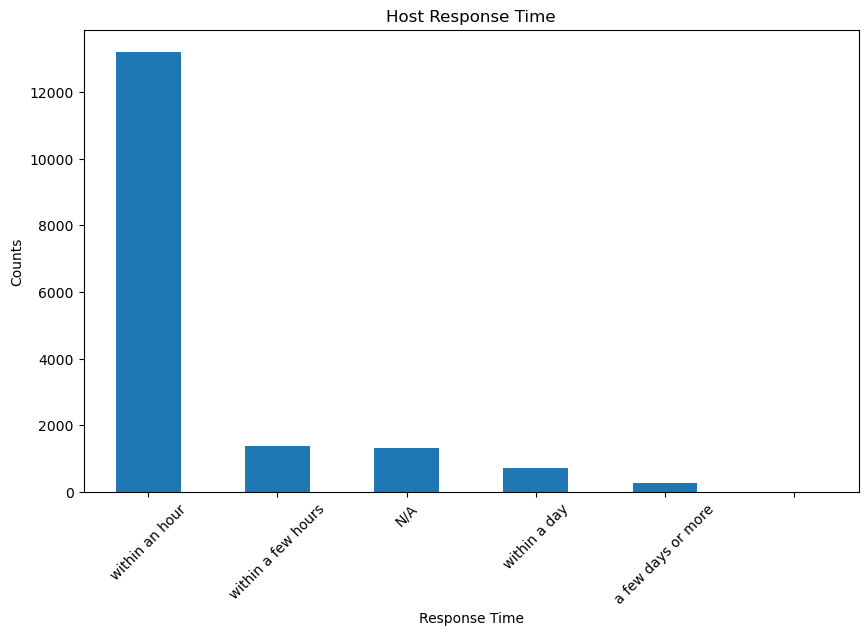

In [34]:
# Calculate the counts for each category for Host Response Time
category_counts = listings_detailed_df['host_response_time'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Host Response Time')
plt.xlabel('Response Time')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.show()

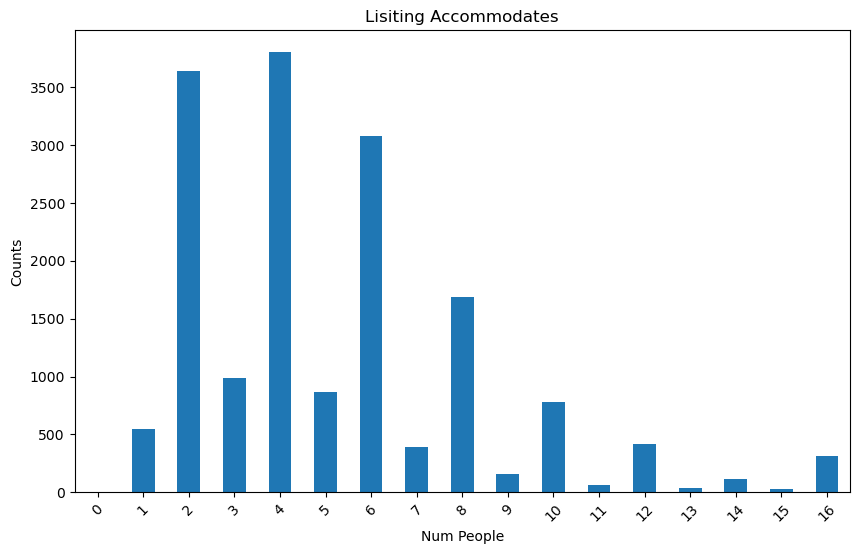

In [35]:
category_counts = listings_detailed_df['accommodates'].value_counts()

# Sort the index (which in this case represents the number of days) to ensure numeric order
category_counts = category_counts.sort_index()

# Plotting
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Lisiting Accommodates')
plt.xlabel('Num People')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.show()

#### Number of each different Room Type graphic

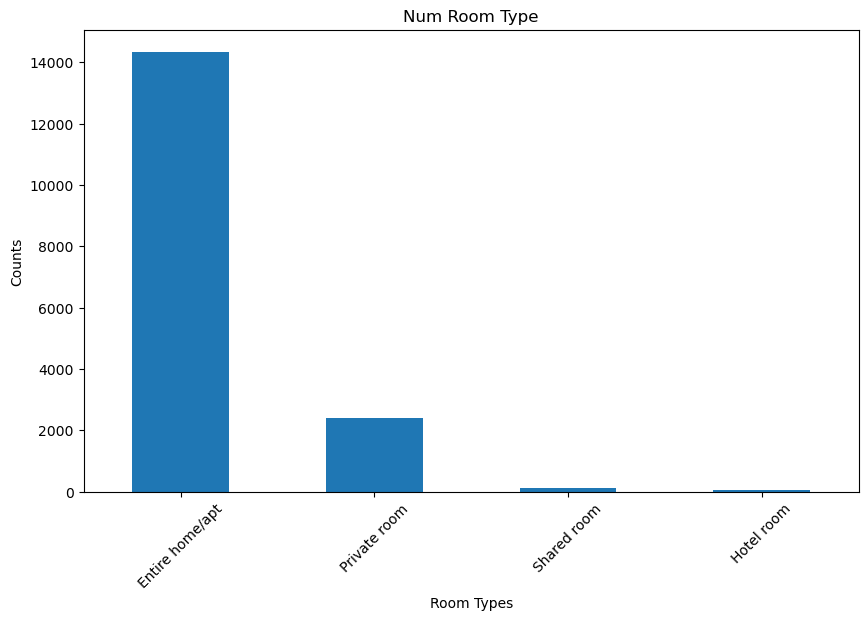

In [36]:
category_counts = listings_detailed_df['room_type'].value_counts()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Num Room Type')
plt.xlabel('Room Types')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.show()

#### Create histogram graphics of the following numeric columns - with mean, standard deviation, and median

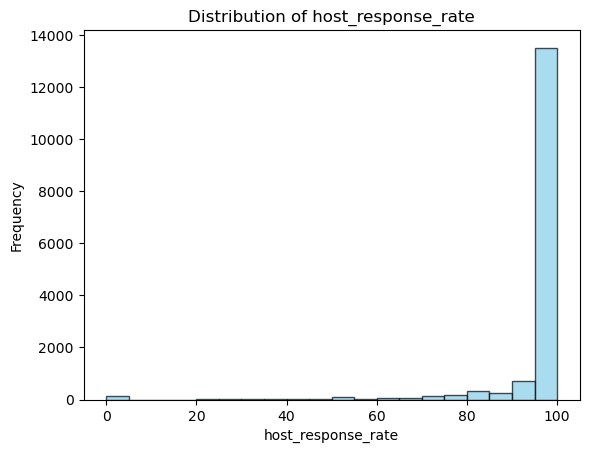

Standard Deviation of host_response_rate: 12.714436098241613
Mean of host_response_rate: 96.17487321050267
Median of host_response_rate: 100.0




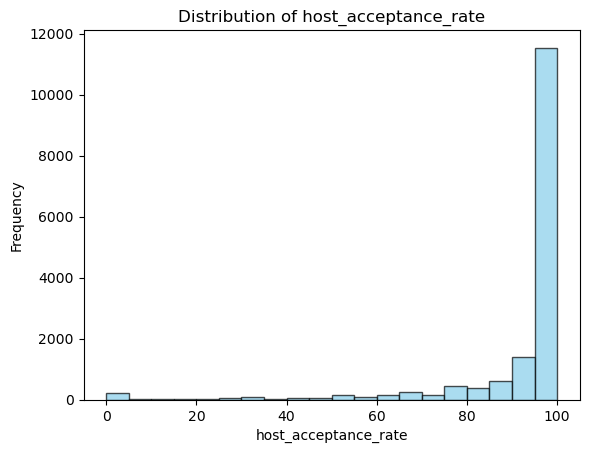

Standard Deviation of host_acceptance_rate: 17.436378381528424
Mean of host_acceptance_rate: 92.18053793453439
Median of host_acceptance_rate: 99.0




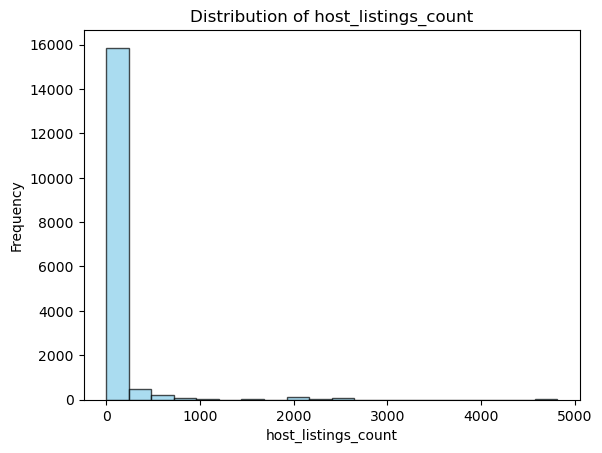

Standard Deviation of host_listings_count: 314.6974415869272
Mean of host_listings_count: 74.53633566102498
Median of host_listings_count: 6.0




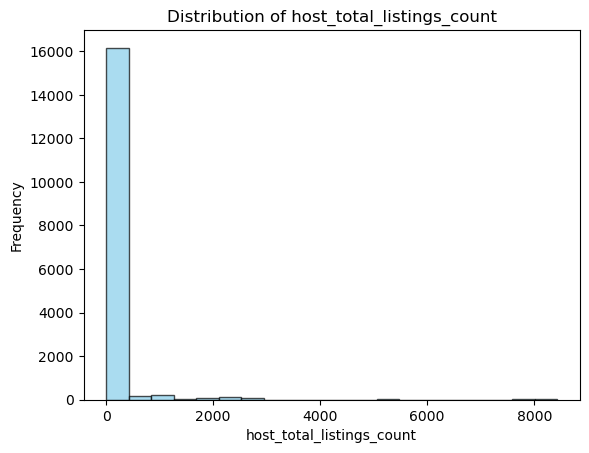

Standard Deviation of host_total_listings_count: 498.31701417756966
Mean of host_total_listings_count: 110.68783287963072
Median of host_total_listings_count: 8.0




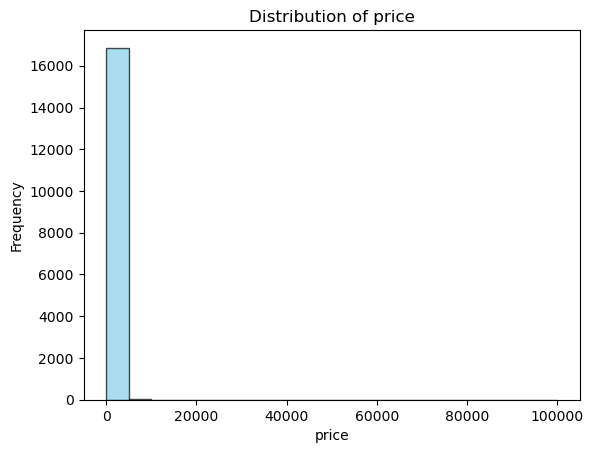

Standard Deviation of price: 903.4119654419727
Mean of price: 311.75430498846083
Median of price: 199.0




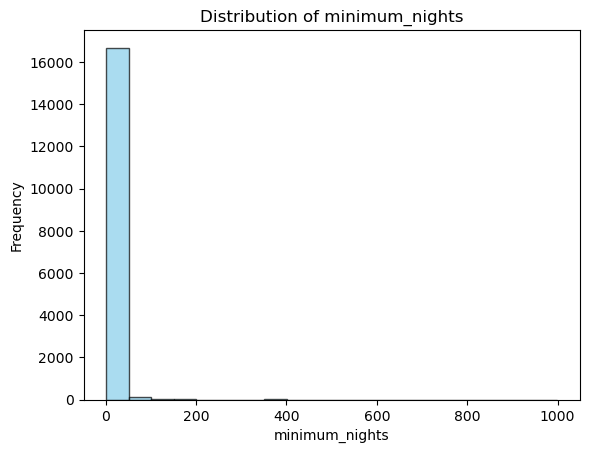

Standard Deviation of minimum_nights: 19.847011870189828
Mean of minimum_nights: 5.3719746730575775
Median of minimum_nights: 2.0




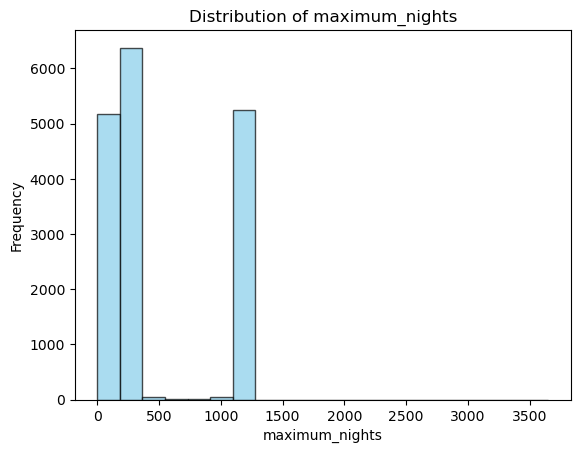

Standard Deviation of maximum_nights: 435.65211822388096
Mean of maximum_nights: 509.64820403574174
Median of maximum_nights: 365.0




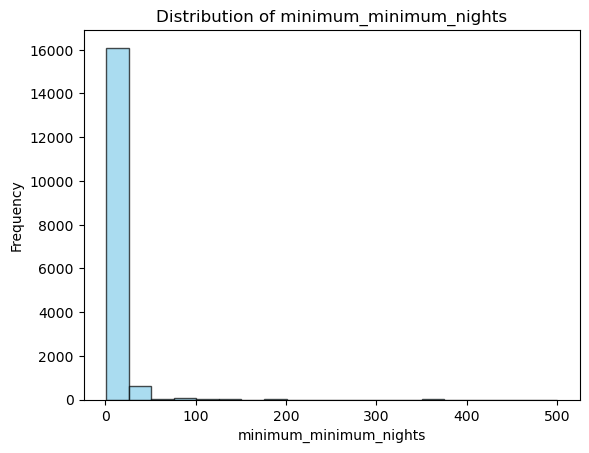

Standard Deviation of minimum_minimum_nights: 15.755782390578117
Mean of minimum_minimum_nights: 4.767382685365998
Median of minimum_minimum_nights: 2.0




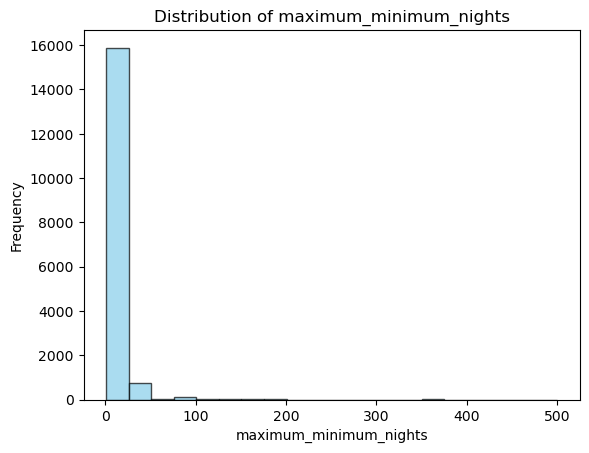

Standard Deviation of maximum_minimum_nights: 19.51635777372641
Mean of maximum_minimum_nights: 6.696964317415231
Median of maximum_minimum_nights: 3.0




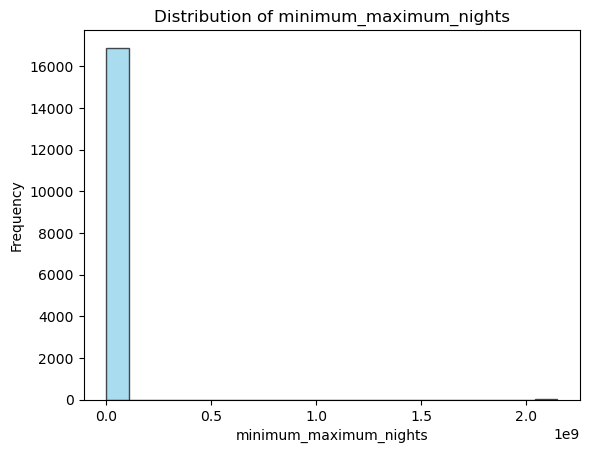

Standard Deviation of minimum_maximum_nights: 46714772.92299731
Mean of minimum_maximum_nights: 1017321.6872596012
Median of minimum_maximum_nights: 1125.0




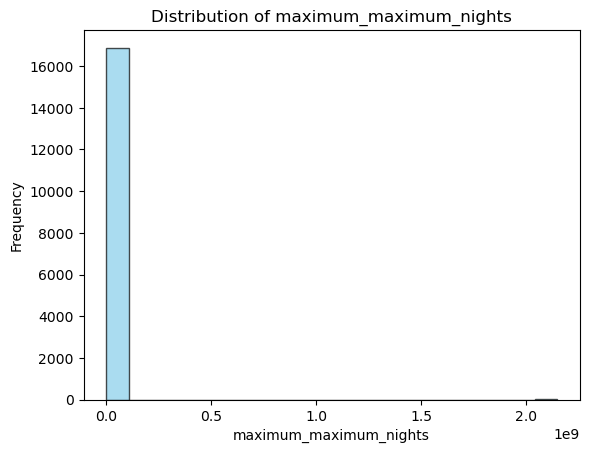

Standard Deviation of maximum_maximum_nights: 49547031.32534256
Mean of maximum_maximum_nights: 1144443.0710692941
Median of maximum_maximum_nights: 1125.0




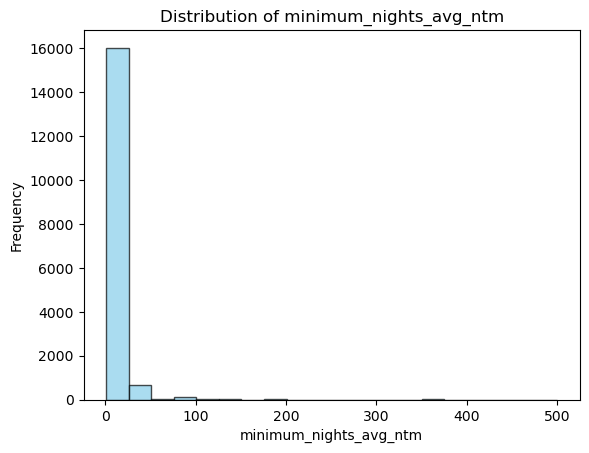

Standard Deviation of minimum_nights_avg_ntm: 18.73196174097512
Mean of minimum_nights_avg_ntm: 5.911692999585783
Median of minimum_nights_avg_ntm: 2.9




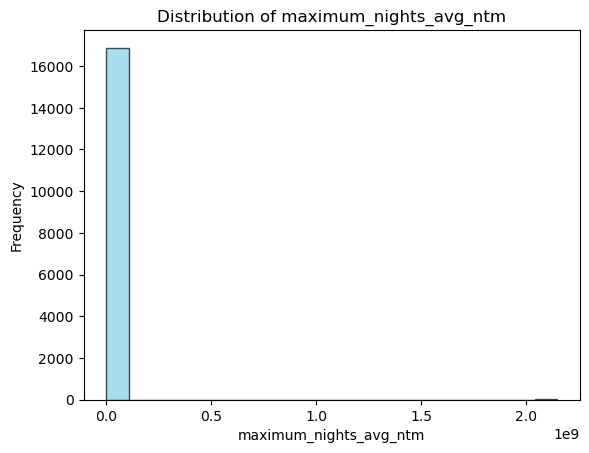

Standard Deviation of maximum_nights_avg_ntm: 49534532.42126773
Mean of maximum_nights_avg_ntm: 1144140.3043020302
Median of maximum_nights_avg_ntm: 1125.0




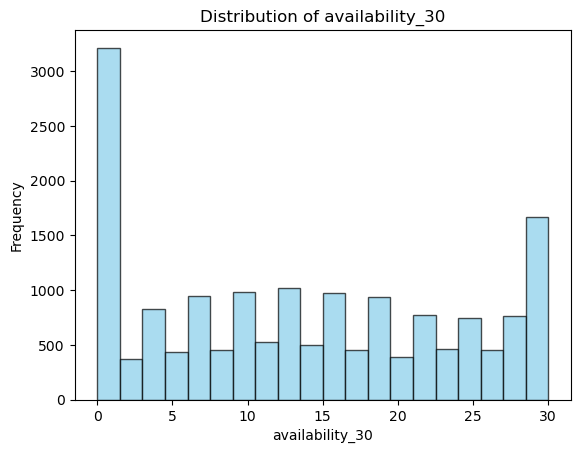

Standard Deviation of availability_30: 10.068328258268222
Mean of availability_30: 13.41174033966507
Median of availability_30: 13.0




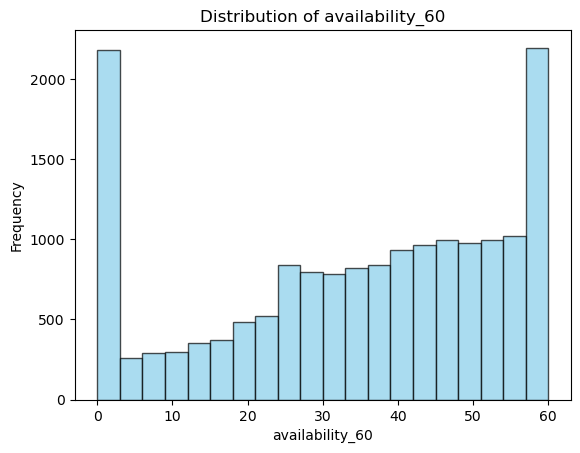

Standard Deviation of availability_60: 19.330277372636026
Mean of availability_60: 33.95952423220309
Median of availability_60: 37.0




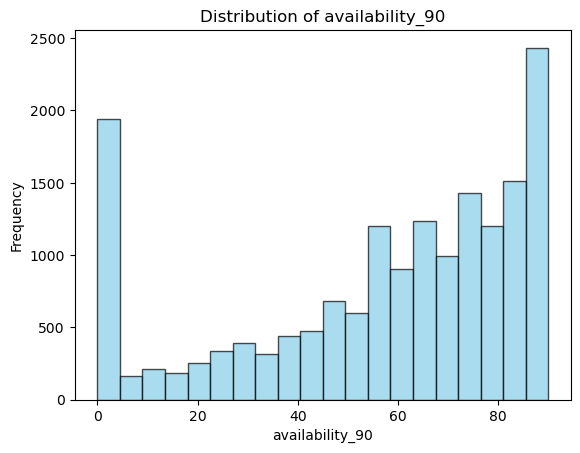

Standard Deviation of availability_90: 28.40000963520851
Mean of availability_90: 56.5124563583644
Median of availability_90: 64.0




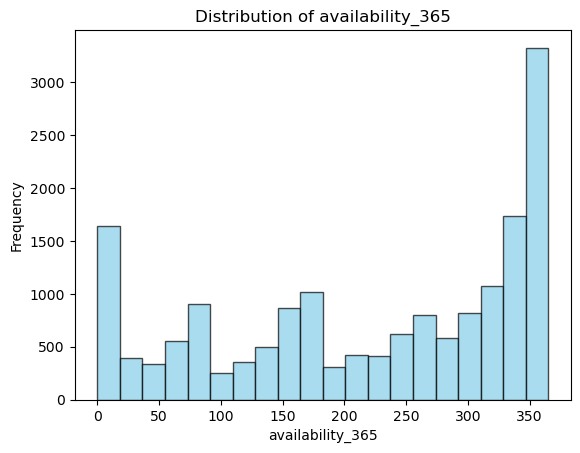

Standard Deviation of availability_365: 123.61059225917647
Mean of availability_365: 220.36522871175808
Median of availability_365: 253.0




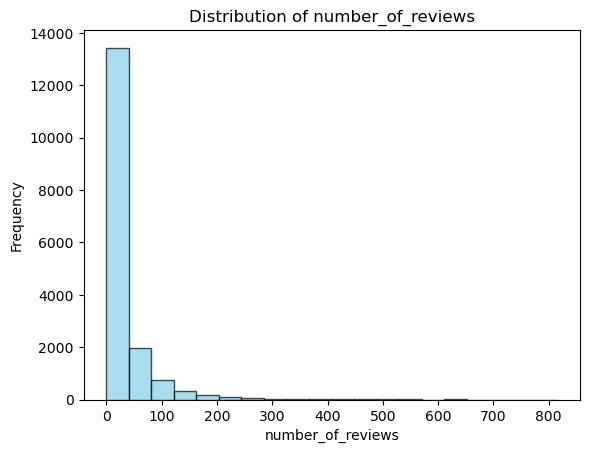

Standard Deviation of number_of_reviews: 51.468890055697884
Mean of number_of_reviews: 28.083851115450617
Median of number_of_reviews: 10.0




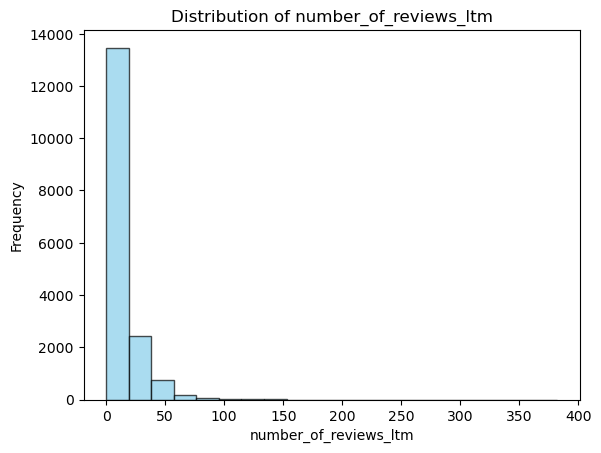

Standard Deviation of number_of_reviews_ltm: 15.409520411903204
Mean of number_of_reviews_ltm: 11.00692348659684
Median of number_of_reviews_ltm: 5.0




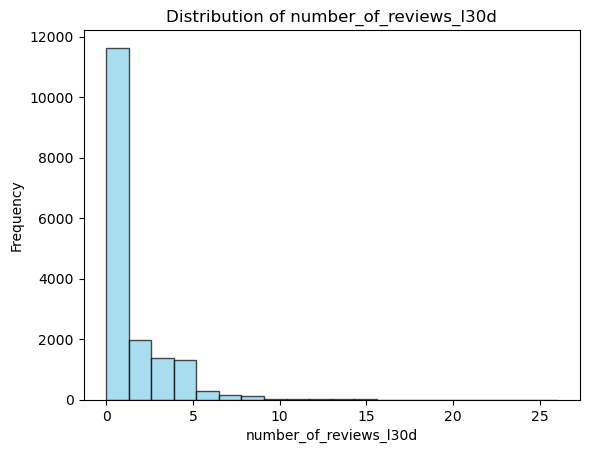

Standard Deviation of number_of_reviews_l30d: 1.854828467739811
Mean of number_of_reviews_l30d: 1.249896443576543
Median of number_of_reviews_l30d: 0.0




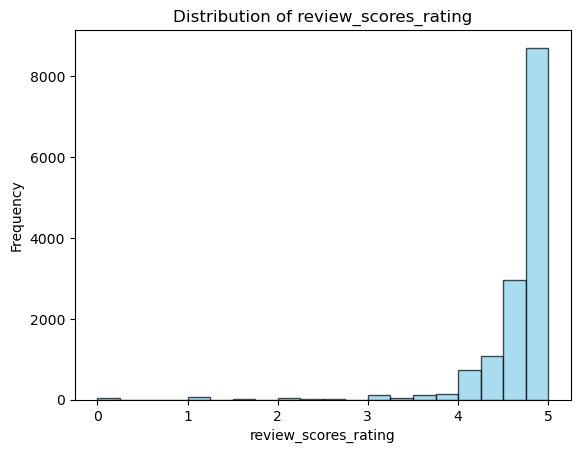

Standard Deviation of review_scores_rating: 0.522451771689398
Mean of review_scores_rating: 4.683910539041386
Median of review_scores_rating: 4.83




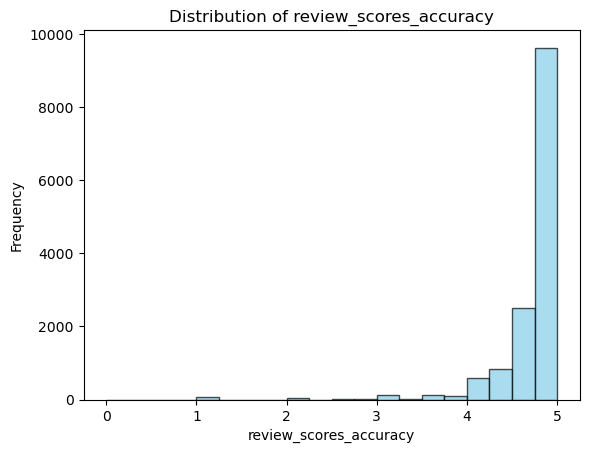

Standard Deviation of review_scores_accuracy: 0.4552307699180687
Mean of review_scores_accuracy: 4.732923768095287
Median of review_scores_accuracy: 4.87




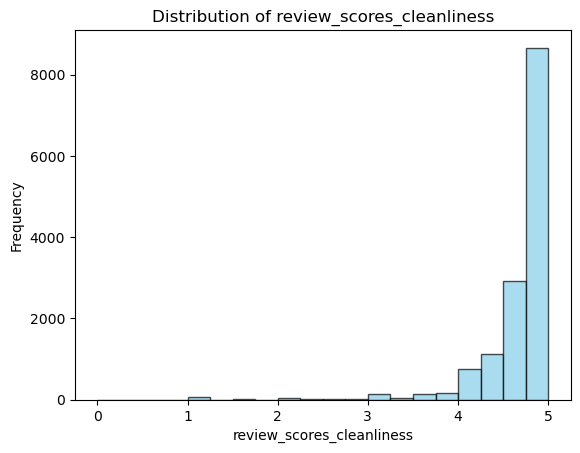

Standard Deviation of review_scores_cleanliness: 0.46211723785005937
Mean of review_scores_cleanliness: 4.695634315053839
Median of review_scores_cleanliness: 4.83




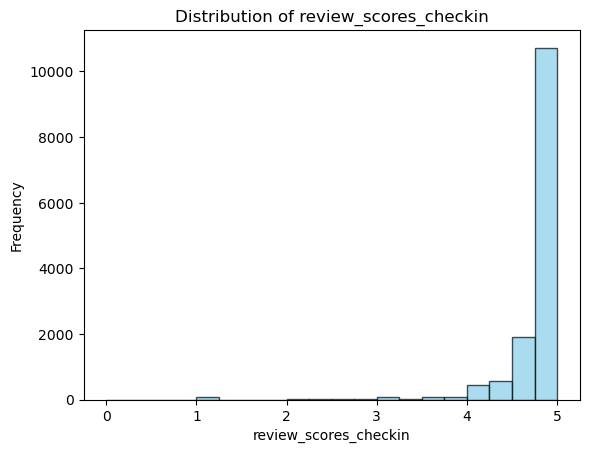

Standard Deviation of review_scores_checkin: 0.42355154232643755
Mean of review_scores_checkin: 4.793568423304601
Median of review_scores_checkin: 4.94




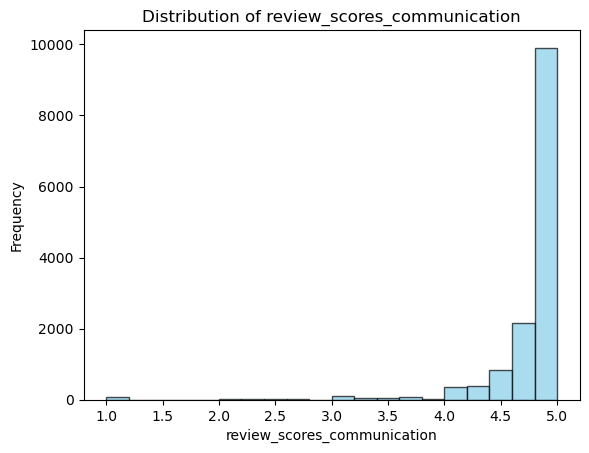

Standard Deviation of review_scores_communication: 0.43343625268328584
Mean of review_scores_communication: 4.791792055908171
Median of review_scores_communication: 4.93




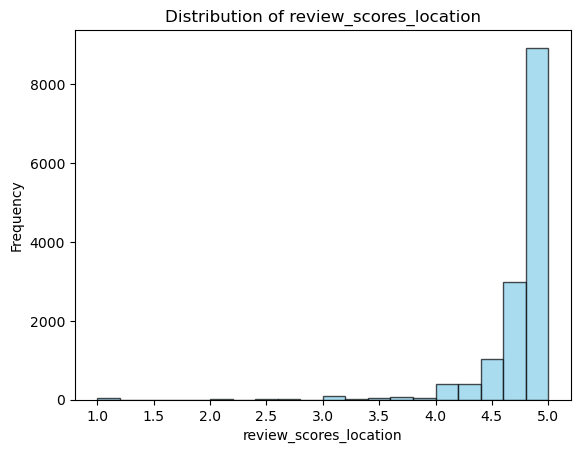

Standard Deviation of review_scores_location: 0.3705867049928006
Mean of review_scores_location: 4.779038722099417
Median of review_scores_location: 4.88




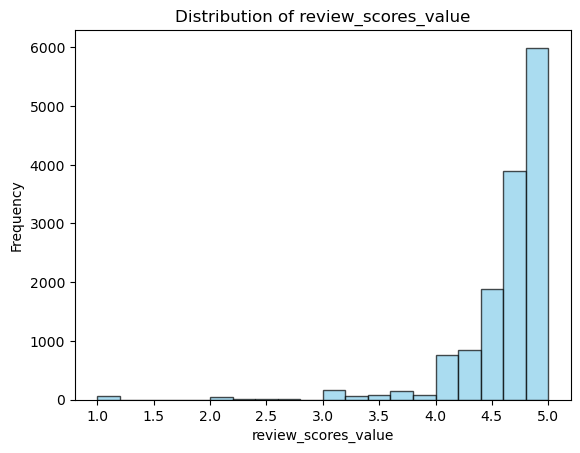

Standard Deviation of review_scores_value: 0.471550797039808
Mean of review_scores_value: 4.641546031519647
Median of review_scores_value: 4.76




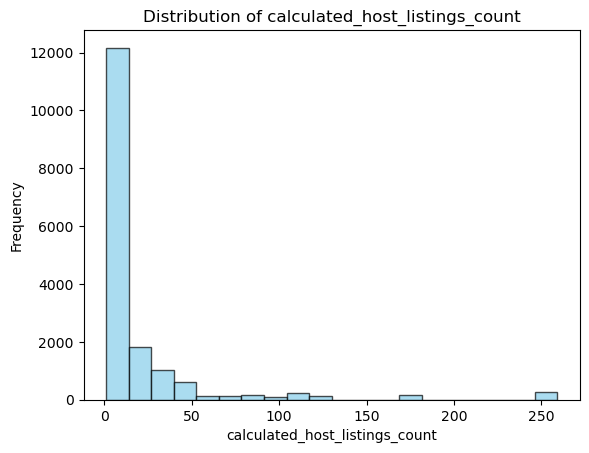

Standard Deviation of calculated_host_listings_count: 40.525623682406426
Mean of calculated_host_listings_count: 18.621397715841173
Median of calculated_host_listings_count: 4.0




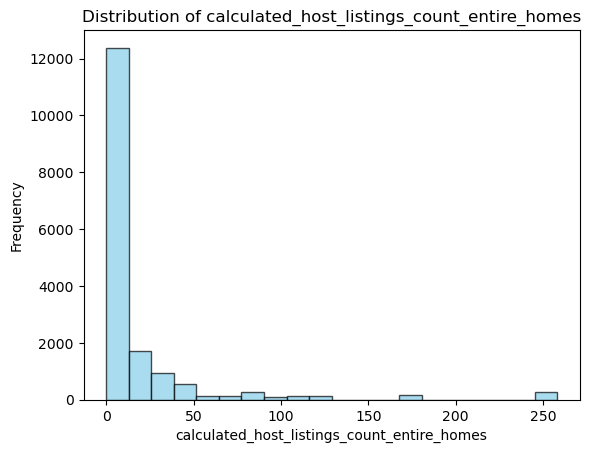

Standard Deviation of calculated_host_listings_count_entire_homes: 40.16919548927346
Mean of calculated_host_listings_count_entire_homes: 17.481507781525533
Median of calculated_host_listings_count_entire_homes: 3.0




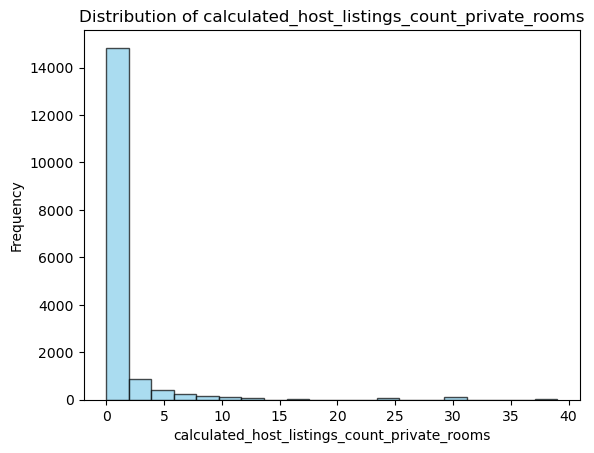

Standard Deviation of calculated_host_listings_count_private_rooms: 3.8641476922055147
Mean of calculated_host_listings_count_private_rooms: 1.0245576661340907
Median of calculated_host_listings_count_private_rooms: 0.0




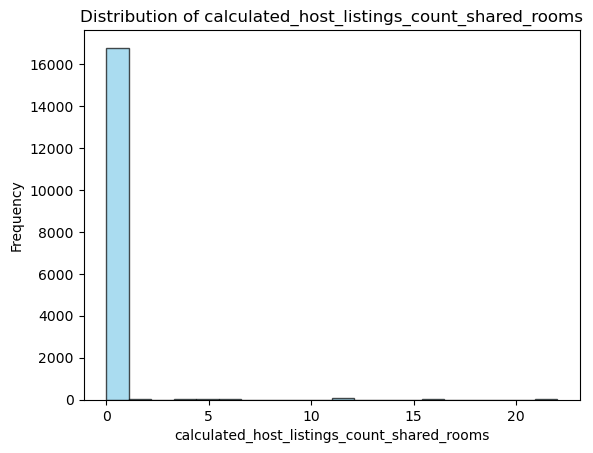

Standard Deviation of calculated_host_listings_count_shared_rooms: 1.207154410897663
Mean of calculated_host_listings_count_shared_rooms: 0.09817148943724481
Median of calculated_host_listings_count_shared_rooms: 0.0




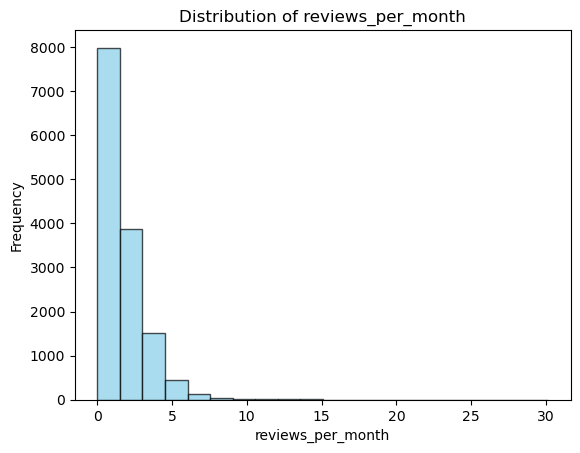

Standard Deviation of reviews_per_month: 1.5531328108915479
Mean of reviews_per_month: 1.6657929170815062
Median of reviews_per_month: 1.23




In [37]:

columns_to_analyze = [
    'host_response_rate',
    'host_acceptance_rate',
    'host_listings_count',
    'host_total_listings_count',
    'price',
    'minimum_nights',
    'maximum_nights',
    'minimum_minimum_nights',
    'maximum_minimum_nights',
    'minimum_maximum_nights',
    'maximum_maximum_nights',
    'minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm',
    'availability_30',
    'availability_60',
    'availability_90',
    'availability_365',
    'number_of_reviews',
    'number_of_reviews_ltm',
    'number_of_reviews_l30d',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms',
    'reviews_per_month'
]

# Iterating through each specified column in the list
for column in columns_to_analyze:
    # Plotting the histogram for the column
    listings_detailed_df[column].plot.hist(bins=20, edgecolor='black', color='skyblue', alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

    # Calculating statistics
    std_value = listings_detailed_df[column].std()
    mean_value = listings_detailed_df[column].mean()
    median_value = listings_detailed_df[column].median()

    print(f'Standard Deviation of {column}: {std_value}')
    print(f'Mean of {column}: {mean_value}')
    print(f'Median of {column}: {median_value}')
    print("\n")  # Adds a newline for better readability between outputs

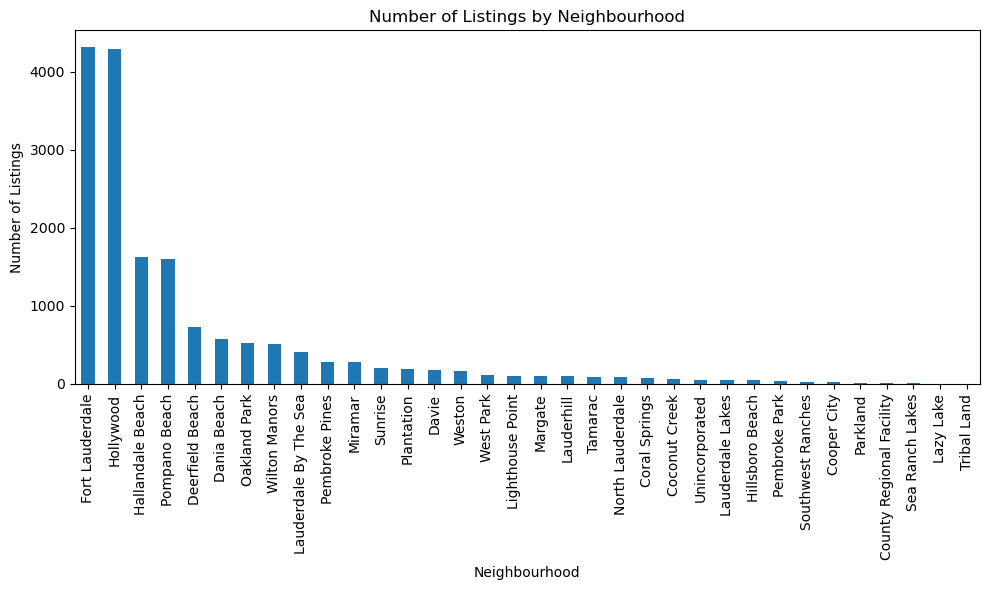

In [38]:
# Group by neighbourhood_cleansed and count the number of listings
neighborhood_counts = listings_detailed_df['neighbourhood_cleansed'].value_counts()

plt.figure(figsize=(10, 6))
neighborhood_counts.plot(kind='bar')
plt.title('Number of Listings by Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Number of Listings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 3. listings_df EDA

In [39]:
listings_df = pd.read_csv(listings_path,  na_filter=False)

listings_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,484515,MIAMI- AMAZING APARTMENT OVER BEACH,637272,Bianca,,Hollywood,25.993770,-80.118300,Entire home/apt,297,7,27,2021-03-19,0.21,6,364,0,
1,827736378366911479,Legion 1BR/1BA,475630606,Sean,,Fort Lauderdale,26.093936,-80.137591,Entire home/apt,222,1,0,,,1,356,0,
2,592589963829194972,Club Wyndham Royal Vista,66506549,Ryan,,Pompano Beach,26.223850,-80.090990,Private room,500,1,0,,,5,365,0,
3,45990221,SPACIOUS 1 BEDROOM DELUXE-Wyndham Palm-Aire Re...,365280298,ResortShare,,Pompano Beach,26.226130,-80.158590,Entire home/apt,162,2,162,2022-10-20,5.50,5,310,59,
4,11972837,"Palm-Aire, Fort Lauderdale, FL, 2 Bedroom #1",10981379,Jan,,Pompano Beach,26.226220,-80.158710,Entire home/apt,258,1,35,2022-09-06,0.46,23,6,6,


#### Determine if there are any missing values

In [40]:
pd.set_option('display.max_columns', None)  # Adjust to see all columns
pd.set_option('display.max_rows', None)  # Adjust to see all rows

missing_values_count = listings_df.isna().sum()

# Filter to only show columns with missing values > 0
missing_values_count = missing_values_count[missing_values_count > 0]

print(missing_values_count)
# No values missing

Series([], dtype: int64)


In [41]:
listings_df.shape

(16899, 18)

In [42]:
for column in listings_df.columns:
    # Determine if the column is numeric
    if pd.api.types.is_numeric_dtype(listings_df[column]):
        min_value = listings_df[column].min()
        max_value = listings_df[column].max()
        print(f"{column} (Numerical): Range = {min_value} to {max_value}")
    else:
        # For categorical data, display unique values (or count of unique values if too many)
        unique_values = listings_df[column].unique()
        if len(unique_values) <= 20:  # Arbitrarily chosen threshold for display
            print(f"{column} (Categorical): Categories = {unique_values}")
        else:
            print(f"{column} (Categorical): {len(unique_values)} unique categories")


id (Numerical): Range = 57818 to 855979244654886532
name (Categorical): 16068 unique categories
host_id (Numerical): Range = 5146 to 506759471
host_name (Categorical): 3524 unique categories
neighbourhood_group (Categorical): Categories = ['']
neighbourhood (Categorical): 34 unique categories
latitude (Numerical): Range = 25.957322957283782 to 26.33341
longitude (Numerical): Range = -80.42812 to -80.07502
room_type (Categorical): Categories = ['Entire home/apt' 'Private room' 'Hotel room' 'Shared room']
price (Numerical): Range = 0 to 100000
minimum_nights (Numerical): Range = 1 to 999
number_of_reviews (Numerical): Range = 0 to 815
last_review (Categorical): 996 unique categories
reviews_per_month (Categorical): 757 unique categories
calculated_host_listings_count (Numerical): Range = 1 to 259
availability_365 (Numerical): Range = 0 to 365
number_of_reviews_ltm (Numerical): Range = 0 to 382
license (Categorical): Categories = ['']


## 4. reviews_detailed_df

In [43]:
reviews_detailed_df = pd.read_csv(reviews_detailed_path,  na_filter=False)

reviews_detailed_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,69824,234005937,2018-02-11,125884157,Josh,The host canceled this reservation 314 days be...
1,83449,678317,2011-11-01,327476,Tina,"très bon accueil, grand appartement très bien ..."
2,83449,873042,2012-01-20,774229,Dávid,"Very well equipped (especially the kitchen), s..."
3,83449,9303053,2013-12-19,49374,Carmen,The reservation was canceled 8 days before arr...
4,83449,11547659,2014-04-07,12855971,Charlene,It was an incredible experience....the place i...


In [44]:
reviews_detailed_df.shape

(474589, 6)

#### Determine if there are any missing values

In [148]:
pd.set_option('display.max_columns', None)  # Adjust to see all columns
pd.set_option('display.max_rows', None)  # Adjust to see all rows

missing_values_count = reviews_detailed_df.isna().sum()

# Filter to only show columns with missing values > 0
missing_values_count = missing_values_count[missing_values_count > 0]

print(missing_values_count)
# No values missing

Series([], dtype: int64)


In [149]:
# Get number of reviewers who have given over 1 review
num_reviewers_gt_1 = reviews_detailed_df[reviews_detailed_df['reviewer_id'] > 1]['reviewer_id'].nunique()

print(num_reviewers_gt_1)


408800


#### Create a graphic on how many reviewers a reviewer a written

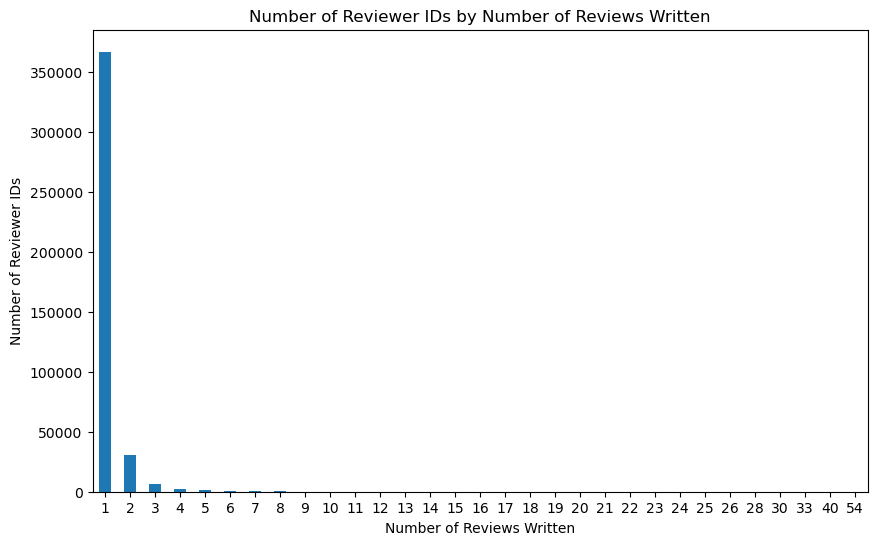

In [45]:
# Calculate the counts of reviews for each reviewer_id
review_counts_per_reviewer = reviews_detailed_df['reviewer_id'].value_counts()

# Aggregate these counts to find out how many reviewers have written N reviews
# This gives us the count of reviewer_ids for each review count.
aggregated_review_counts = review_counts_per_reviewer.value_counts().sort_index()

aggregated_review_counts.plot(kind='bar', figsize=(10, 6))

plt.title('Number of Reviewer IDs by Number of Reviews Written')
plt.xlabel('Number of Reviews Written')
plt.ylabel('Number of Reviewer IDs')
plt.xticks(rotation=0)
plt.show()

#### Seeing Number of Reviewers who have written over 1 review

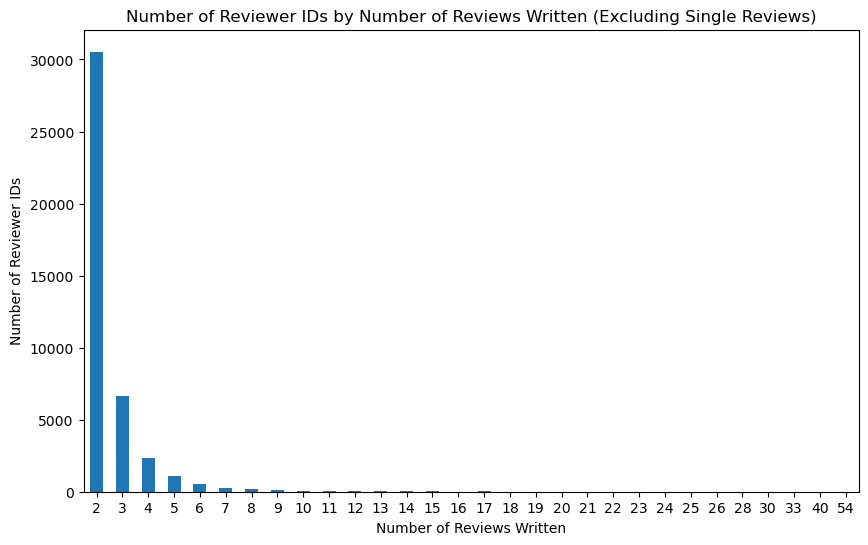

In [46]:
# Calculate the counts of reviews for each reviewer_id
review_counts_per_reviewer = reviews_detailed_df['reviewer_id'].value_counts()

# Filter out reviewer_ids that have written only one review
review_counts_filtered = review_counts_per_reviewer[review_counts_per_reviewer > 1]

# Aggregate these filtered counts to find out how many reviewers have written N reviews
# This gives us the count of reviewer_ids for each review count (excluding those who wrote only once).
aggregated_review_counts_filtered = review_counts_filtered.value_counts().sort_index()

aggregated_review_counts_filtered.plot(kind='bar', figsize=(10, 6))

plt.title('Number of Reviewer IDs by Number of Reviews Written (Excluding Single Reviews)')
plt.xlabel('Number of Reviews Written')
plt.ylabel('Number of Reviewer IDs')
plt.xticks(rotation=0)
plt.show()

## 5. reviews_df

In [152]:
reviews_df = pd.read_csv(reviews_path,  na_filter=False)

reviews_df.head()

,listing_id,date
0,57818,2013-01-03
1,57818,2013-01-23
2,57818,2013-01-28
3,57818,2013-02-05
4,57818,2013-02-11


In [153]:
reviews_df.shape

(474589, 2)

In [154]:
pd.set_option('display.max_columns', None)  # Adjust to see all columns
pd.set_option('display.max_rows', None)  # Adjust to see all rows

missing_values_count = reviews_detailed_df.isna().sum()

# Filter to only show columns with missing values > 0
missing_values_count = missing_values_count[missing_values_count > 0]

print(missing_values_count)
# No values missing

Series([], dtype: int64)


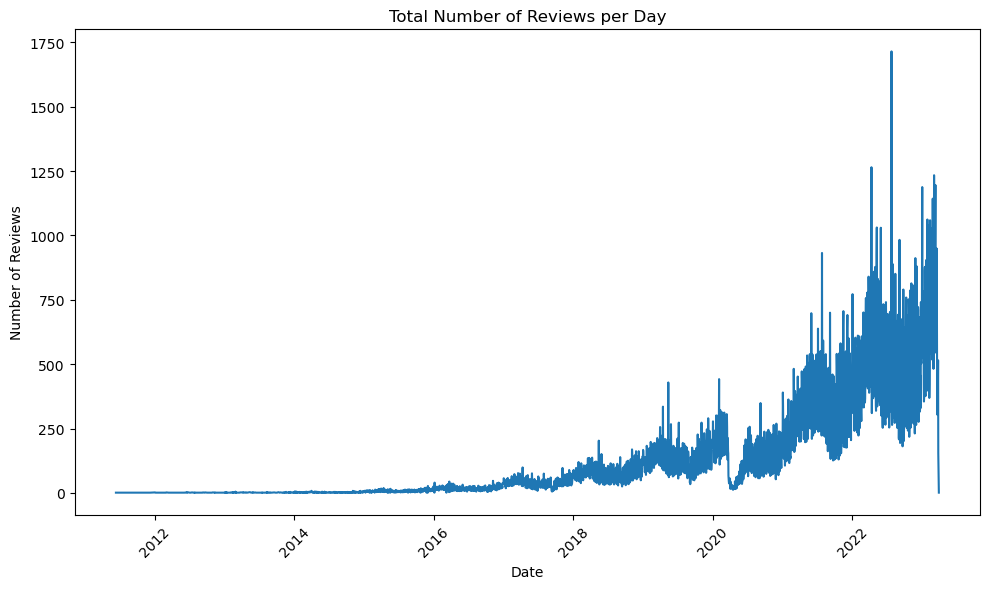

In [155]:
# Ensure the date column is in datetime format without timestamp
reviews_df['date'] = pd.to_datetime(reviews_df['date']).dt.date

# Group by the date column and count the number of reviews for each day
daily_review_counts = reviews_df.groupby('date').size()

daily_review_counts.plot(kind='line', figsize=(10, 6))

plt.title('Total Number of Reviews per Day')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. neighborhooud

Nothing to additional to do EDA on

In [156]:
neighbourhoods_df = pd.read_csv(neighbourhoods_path,  na_filter=False)

neighbourhoods_df.head()

,neighbourhood_group,neighbourhood
0,,Coconut Creek
1,,Cooper City
2,,Coral Springs
3,,County Regional Facility
4,,Dania Beach


In [157]:
neighbourhoods_df.shape

(34, 2)

## 7. geojson

In [47]:
neighbourhoods_json_df = pd.read_json(neighbourhoods_json_path)

neighbourhoods_json_df.head()

,type,features
0,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Mult..."
1,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Mult..."
2,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Mult..."
3,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Mult..."
4,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Mult..."


In [48]:
neighbourhoods_json_df.shape

(89, 2)

In [49]:
pd.set_option('display.max_columns', None)  # Adjust to see all columns
pd.set_option('display.max_rows', None)  # Adjust to see all rows

missing_values_count = neighbourhoods_json_df.isna().sum()

# Filter to only show columns with missing values > 0
missing_values_count = missing_values_count[missing_values_count > 0]

print(missing_values_count)

Series([], dtype: int64)


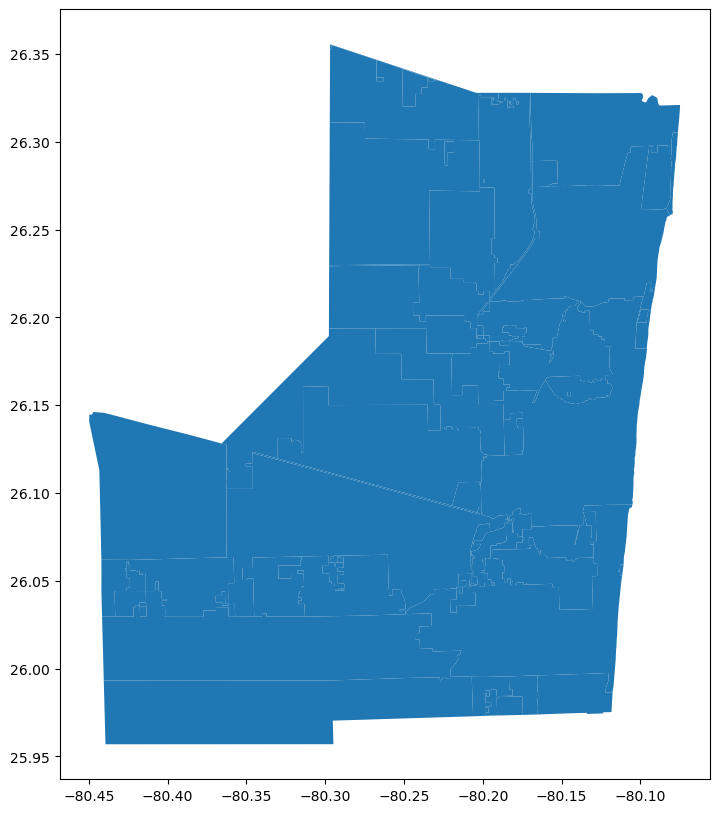

In [51]:
# Load the GeoJSON data into a GeoDataFrame
gdf = gpd.read_file(neighbourhoods_json_path)

# Plotting the geometries - showing broward county map
gdf.plot(figsize=(10, 10))
plt.show()
